## Compressed sensing

O conceito básico que relaciona compressão e esparsidade é a ideia de representar um sinal comprimível $x \in \mathbb{R}^n$ como
$$x = \Psi s,$$
onde $\Psi \in \mathbb{R}^{n \times n}$ é a base de uma transformação e $s \in \mathbb{R}^n$ é um vetor esparso,
ou seja, cujos elementos são, em maioria, $0s$.

O compressed sensing segue essa mesma linha.

Digamos que $y$ é um vetor que contem uma série de medições realizadas por um sensor.
Queremos encontrar $\Theta s = y$ de forma que $s$ seja o mais esparso possível.

A condição de "$s$ tem que ser o mais esparso possível" pode ser representada a partir da $\ell_0$,
onde $|| \cdot ||_0$ denota a quantidade de elementos não nulos do vetor.
Nosso objetivo então seria encontrar $\hat{s}$ tal que
$$\hat{s} = \arg \min_s ||s||_0, \ \text{sujeito a} \ y = \Theta s.$$

Para maior eficiência, Brunton traz um algoritmo que realiza essa otimização utilziando mínimos quadrados sequenciais e norma $\ell_1$,
que já faz com que a maioria dos membros de $s$ fique muito próximos de 0, como veremos a seguir.

Para tornar o vetor de fato esparso, é possível aplicar algum cutoff com tolerância em $s$, onde elementos
tornam-se 0 a partir de um certo valor.

**Reprodução dos exemplos da seção 3.3** (Brunton, Kutz)

Resolvendo um sistema $y = \Theta s$ com compressed sensing.

Usamos mínimos quadrados sequenciais.

In [16]:
from scipy.optimize import minimize
from scipy.fftpack import dct, idct
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# gerando os dados
n = 1000 # dimensão de s
p = 200 # nro. de amostras, dim(y)

In [18]:
np.random.seed(6661)
Theta = np.random.randn(p, n)
y = np.random.randn(p)

In [19]:
# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x, ord=1)

In [20]:
constr = ({'type': 'eq', 'fun': lambda x: Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP', constraints=constr)
s_L1 = res.x

In [21]:
s_L1

array([-2.63761389e-02, -7.31817567e-05, -1.86676011e-03,  4.32835187e-04,
       -3.49472885e-02, -3.45152204e-05,  4.27225188e-02, -2.27578683e-04,
        1.53419715e-05,  2.96213001e-05,  7.04561855e-05,  1.43893906e-03,
       -6.62705539e-03, -1.20652521e-04,  1.72846974e-04,  8.27289589e-02,
       -1.01132108e-02,  1.46573445e-04, -2.75857148e-05, -3.73364264e-05,
        9.02854766e-05,  1.38002763e-01,  2.95837325e-04,  4.43943184e-03,
        2.90009568e-04,  1.83367803e-05, -2.58201985e-05,  2.20857041e-03,
       -1.41147384e-03, -6.08270044e-03,  5.01136790e-05,  1.00400648e-03,
        8.88356035e-05,  3.68726148e-02,  1.85291756e-04,  2.68558362e-04,
       -9.35982765e-05,  9.95642667e-05, -1.08386427e-04, -4.90678917e-05,
        4.16993721e-04, -2.44467396e-03, -4.12992532e-03, -1.99559280e-02,
       -1.71917357e-05,  2.24505980e-05,  1.65499792e-04, -2.41578793e-03,
       -1.50618429e-02, -6.06104441e-03, -8.55270441e-04, -2.70830460e-04,
        1.07613246e-05,  

Vemos que $s$ não é, de fato, esparso, mas tem muitos elementos muito próximos de 0.

In [22]:
# podemos esparsificar s se quisermos. não farei isso
#s_L1[np.abs(s_L1) < 1e-5] = 0

In [23]:
y_L1 = Theta @ s_L1

In [24]:
# error
error_L1 = np.linalg.norm(y - y_L1)
print(error_L1)

1.1303782330887903e-08


Erro muito baixo. Nossa representação esparsa provavelmente ficou boa!

Vamos visualizar.

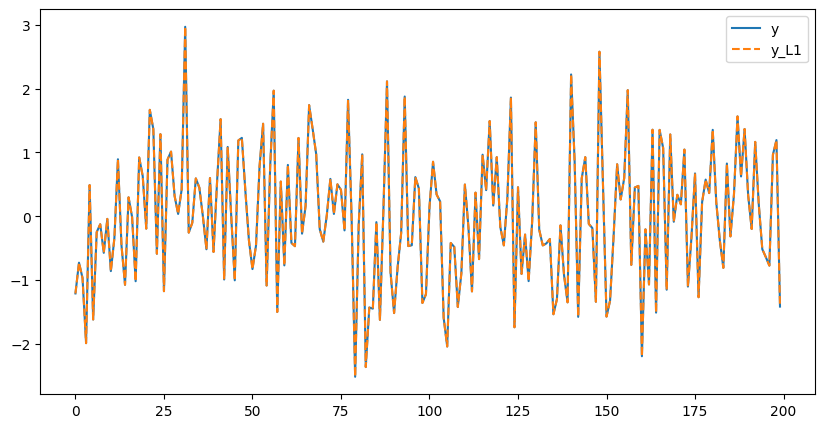

In [25]:
# plot y vs y_L1
fig, ax = plt.subplots(figsize=(10, 5))
# 200 x points
x = np.arange(0, p, 1)
ax.plot(x, y, label='y')
# dashed
ax.plot(x, y_L1, label='y_L1', linestyle='dashed')
ax.legend()
plt.show()

### Recuperando um sinal de áudio a partir de sensoriamento esparso

Agora o desafio é um pouco maior. A partir de dados esparsos (e.g. alguns poucos sensores em um grande fenômeno)
tentaremos reconstruir o fenômeno original.

Vamos recuperar um sinal de funçao
$$x(t) = cos(2\pi \times 97t) + cos(2\pi \times 777t)$$
apenas a partir de alguns poucos pontos.

Para tanto, dessa vez utilizaremos um algoritmo chamado CoSaMP, que substitui o processo de minimização $\ell_1$ que fizemos usando a norma-$\ell_1$ + mínimos quadrados sequenciais.

In [27]:
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u, rcond=-1)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

Primeiro, construímos discretamente o sinal dado pela função fornecida.

In [28]:
n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)

Extraímos a densidade espectral de potência do sinal, para comparação posterior.

In [29]:
xt = np.fft.fft(x)
PSD = xt * np.conj(xt) / n

Pegamos 128 pontos aleatórios.

In [30]:
# pegando amostras aleatórias
np.random.seed(6661)
p = 128
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]

In [31]:
perm

array([1833, 3002, 1309, 3589,  214, 3730, 1577, 2821, 3784, 3129, 2212,
       3923, 1682, 2588,  604, 1182,   91, 3186, 2251, 2983, 2017, 3680,
       1035, 1907, 1630, 1945, 3320,  483, 3840, 3530,  655, 2682,  671,
       1386,  665, 2837, 2587, 1160, 3479, 1699, 3449, 3344,  710,  635,
       1486, 2437,  791, 3144, 1687, 3767, 1280, 3368, 1702,   13, 1206,
       1817,  442, 3023, 2336,  302, 3672, 1715, 3062, 1810,  951, 2216,
       2041, 1689,  299, 3604, 3437,  701, 3796, 2033, 3060, 2714,  357,
       2140, 2712, 1205, 1928, 3422, 2211, 2573,  600, 1173,  689, 2879,
         20,  589, 1923, 3429, 3596,  823, 1275, 2635, 3696, 2007,  332,
       1031,  284, 3475,  687, 3908, 2131, 3495, 3155, 1431, 1969, 3512,
       2714, 2547, 3960, 2672,  976,  985, 2018, 1798,  989,  123,  257,
        101, 2979, 3255, 3887, 1231, 1948,  308])

Não se deve tomar os pontos em ordem sequencial e/ou uniforme. Bem interessante!

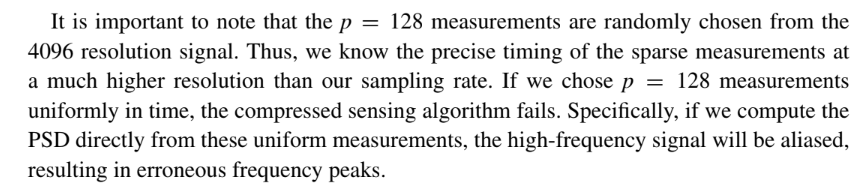

Construímos $\Psi$ como uma biblioteca ortonormal DCT.

In [32]:
Psi = dct(np.eye(n))
Theta = Psi[perm, :]

Otimizamos $y = \Psi s$.

In [33]:
s = cosamp(Theta, y, 10, epsilon=1.e-10, max_iter=1000)

In [34]:
xrecon = idct(s)

In [35]:
to_plt = 500

Plot do original vs aproximado:

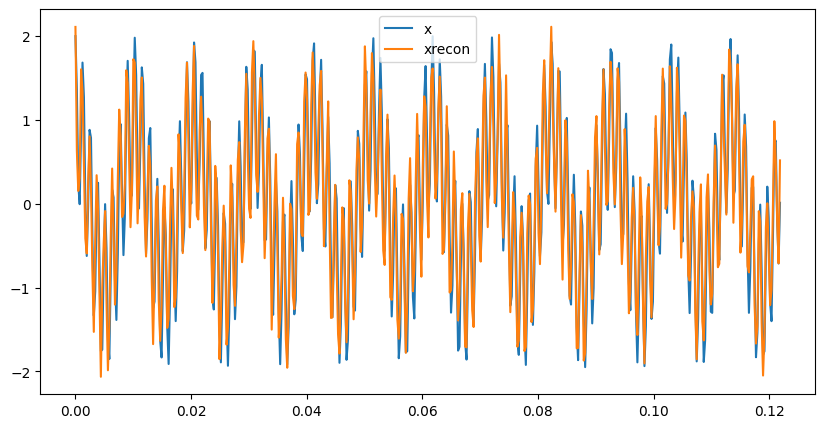

In [36]:
# plot x vs xrecon
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t[:to_plt], x[:to_plt], label='x')
ax.plot(t[:to_plt], xrecon[:to_plt], label='xrecon')
ax.legend()
plt.show()

Prot original vs aproximado, lado a lado:

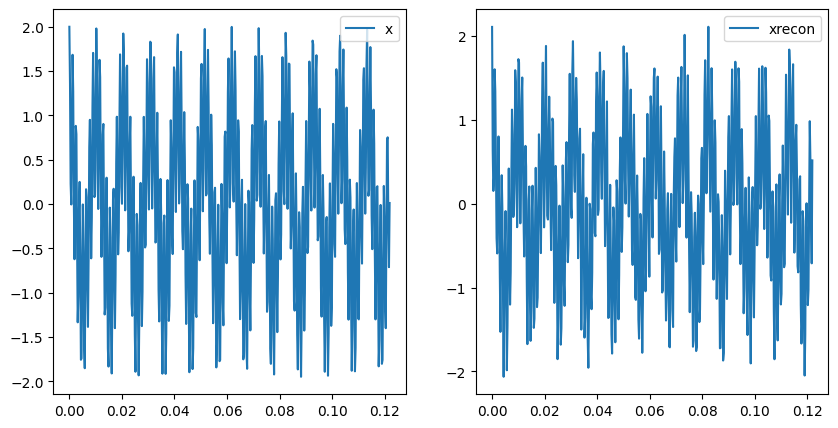

In [37]:
# x vs xrecon, side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(t[:to_plt], x[:to_plt], label='x')
axs[0].legend()
axs[1].plot(t[:to_plt], xrecon[:to_plt], label='xrecon')
axs[1].legend()
plt.show()

Comparando também a densidade espectral, como métrica para ver se a aproximação ficou boa.

Abaixo, também estão marcados em vermelho os pontos tomados para fazer a reconstrução esparsa.

In [38]:
# build psd of xrecon
xtrecon = np.fft.fft(xrecon)
PSDrecon = xtrecon * np.conj(xtrecon) / n

In [39]:
# get perm <= to_plt
perm_that_appear = perm[perm <= to_plt]
y_that_appear = x[perm_that_appear]
t_that_appear = t[perm_that_appear]

f:\Documentos\Unesp\ALCD\posmac-alcd\env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
f:\Documentos\Unesp\ALCD\posmac-alcd\env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


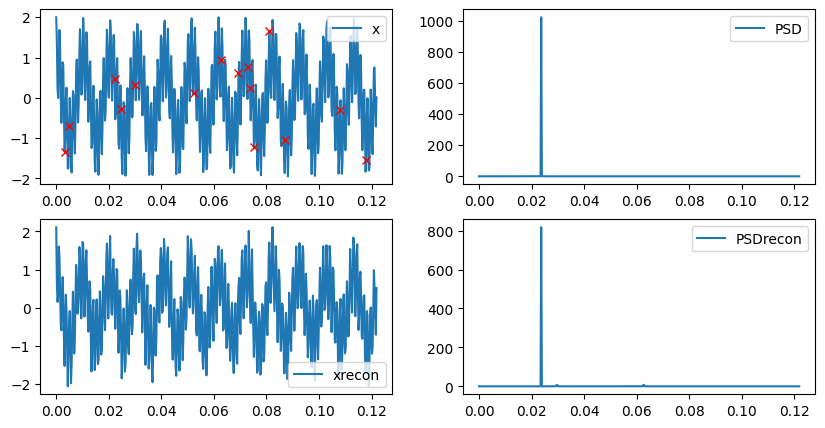

In [40]:
# plot 2x2
# left x, xrecond
# right PSD, PSDrecon
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0, 0].plot(t[:to_plt], x[:to_plt], label='x')
# plot perm_that_appear as red crosses
axs[0, 0].plot(t_that_appear.real, y_that_appear.real, 'rx')
axs[0, 0].legend()
axs[1, 0].plot(t[:to_plt], xrecon[:to_plt], label='xrecon')
axs[1, 0].legend()
axs[0, 1].plot(t[:to_plt], PSD[:to_plt], label='PSD')
axs[0, 1].legend()
axs[1, 1].plot(t[:to_plt], PSDrecon[:to_plt], label='PSDrecon')
axs[1, 1].legend()
plt.show()